In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shutil
import os
import time
from PIL import Image
from numba import jit
import pickle
from pathlib import Path
import skimage.measure
%matplotlib inline


from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.layers.core import Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.metrics import categorical_crossentropy
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.models import load_model

import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import shutil
import os
import random

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import datasets


from keras.optimizers import Adam

from keras.models import load_model
from sklearn import metrics

Using TensorFlow backend.


In [3]:
# check the nth ('n') of an integer 'num'
def check_nth_bit(num, n):
    return (num>>n)&1

# flip the bit of the integer 'int' at a position 'p'  (staring at 0)
def bitflip(int,p):
    mask = 1 << p
    return (int^ mask)

# count the numbers of 1 on a binarie representetion of an interger n
def CountBits(n):
    n = (n & 0x5555555555555555) + ((n & 0xAAAAAAAAAAAAAAAA) >> 1)
    n = (n & 0x3333333333333333) + ((n & 0xCCCCCCCCCCCCCCCC) >> 2)
    n = (n & 0x0F0F0F0F0F0F0F0F) + ((n & 0xF0F0F0F0F0F0F0F0) >> 4)
    n = (n & 0x00FF00FF00FF00FF) + ((n & 0xFF00FF00FF00FF00) >> 8)
    n = (n & 0x0000FFFF0000FFFF) + ((n & 0xFFFF0000FFFF0000) >> 16)
    n = (n & 0x00000000FFFFFFFF) + ((n & 0xFFFFFFFF00000000) >> 32) 
    return n

# defining n!
@jit
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)

# finding the states that have the maginetization "z"
@jit
def statep(y,z):
    a = 0
    for x in range(0,2**l):
        if (2* CountBits(x)-l) == z:
            y[a] = x
            a += 1
    return (y)

# numbers of states with magnatization x
def num_mag(x):
    y = p = int(factorial(l)//((factorial((x+l)/2))*(factorial(l -((x+l)/2)))))
    return y
            
# find the position in the list of states "s" that are iqual to "b"
@jit
def find_state(s,b):
    for z in range(0,p+1):
        if s[z] == b:
            return(z)

# power method
@jit
def power_iteration(A):
    # Choose a random vector
    y_0 = np.random.rand(A.shape[0])
    #erro precision
    e= 0.000000001
    #convergence constant
    er= 1.0
    it = 0
    while (er >= e):
        # calculate the matrix-by-vector product Ab
        z_1 = np.dot(A, y_0)
        # calculate the norm
        z_1_norm = np.linalg.norm(z_1)
        # renormalize the vector
        y_1 = z_1 / z_1_norm
        z_2 = np.dot(A, y_1)
        z_2_norm = np.linalg.norm(z_2)
        lamb_1 = np.dot(z_2,y_1)/np.dot(y_1,y_1)
        y_2 = z_2/z_2_norm
        z_3 = np.dot(A, y_2)
        z_3_norm = np.linalg.norm(z_3)
        lamb_2 = np.dot(z_3,y_2)/np.dot(y_2,y_2)
        er = abs(lamb_1 - lamb_2)/abs(lamb_2)
        y_0 = z_3/z_3_norm
        it += 1
        #if( it%10 == 0):print('# of interations:',it,';','Precision:', er)
    return (y_0, lamb_2)

@jit
def POWER_METHOD(A,dim):
    for x in range(0,dim):
        A[x,x] -= 2*l
        
    C = np.asarray(power_iteration(A))
    C[1] += 2*l
    return (C)

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.title('RMSE ='+ str(np.round(100000*score)/100000))
    plt.savefig('predct_pool.png')
    plt.show()
    
#plt.switch_backend('agg')

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'mean_squared_error' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'val_mean_squared_error' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig('loss_retrain_pool.png')
    plt.show()
    

    ## Accuracy
    #plt.figure(2)
    #for l in acc_list:
        #plt.plot(epochs, history.history[l], 'b', label='Training Mean Square Error (' + str(format(history.history[l][-1],'.5f'))+')')
    #for l in val_acc_list:
        #plt.plot(epochs, history.history[l], 'g', label='Validation Mean Square Error (' + str(format(history.history[l][-1],'.5f'))+')')

    #plt.title('Mean Square Error')
    #plt.xlabel('Epochs')
    #plt.ylabel('Mean Square Error')
    #plt.legend()
    
    
# ------------------------------------------------------    
# ------------------PLOT CLECIO-------------------------
# ------------------------------------------------------

def plot_regression_results(
        results,results_residuals,
        truth_values,individual_truth_values,
        individual_medians,plot_std=True,
        bin_edges=10,real_data=None,
        plot_dropout_err=True, plot_name='regression.png',
        xlabel='$\\theta_{E}$',ylabel='$\\theta_{E}$',
        xmin=None, xmax=None,
        ymin=None, ymax=None,
        color_std='blue', color_err='green',
        color_pop='magenta',plot_label=None,
        fill_label_std=None, fill_label_err=None,
        figsize=(6, 8),alpha_hist=0.4, 
        pop_error=None,pop_error_residuals=None,
        plot_real_residuals=False):
    """ 
    Funtion to create Plots of true values vs predicted values.
    It also plots residuals and the histogram of true and 
    predicted.
    INPUT:
        results: <list> - a list with the format [bin centers, 
        bin medians, bin standard deviations,bin 1 sigma 
        intervals, i.e., [low,high] limit ,bin 2 sigma intervals 
        ,bin 3 sigma intervals].
        results_residuals: <list> - a list with the format [bin 
        centers, bin median residuals, bin standard deviation
        residuals,bin 1 sigma interval of residuals,bin 2 sigma 
        intervals of residuals, bin 3 sigma intervals of 
        residuals].
        truth_values: <array> - same as np.unique
        (individual_truth_values).
        individual_truth_value: <array> - The non bined truth 
        values for histogram.
        individual_medians: <array> - The non bined predicted 
        medians for histogram.
        plot_std <bool> - If True will plot a standard deviation
        in results and results_residuals
        bin_edges: <array> - Bin edges, used to define a scale 
        only, optional.
        real_data: data points, instead of binned curves to add
        in the plot. if plot_real_residuals=True it must follow 
        the format [true_valules,median,lowlim,highlim,
        median_residual,lowlim_residual,highlim_residual] if 
        plot_real_residuals=False the format is [true_valules,
        median,lowlim,highlim]
        plot_dropout_err: <bool> -  if True will plot the 
        1-sigma, 2-sigma and 3-sigma error in results_catalog 
        and results_residuals.
 
        plot_name: <str> : output plot name.
    OUTPUT:
       Saves a plot with a a path defined in the input plot_name.
    """

    pop_err=pop_error
    pop_err_r=pop_error_residuals
    x_bin,y_bin,y_bin_std,y_bin_percentile1sig,y_bin_percentile2sig,y_bin_percentile3sig=results
    x_bin,yr_bin,yr_bin_std,yr_bin_percentile1sig,yr_bin_percentile2sig,yr_bin_percentile3sig=results_residuals


    if type(xmin)==type(None):
        if type(bin_edges)!=type(10):
            xmin=min(bin_edges)
            xmax=max(bin_edges)
        else:
            xmin=min(x_bin)
            xmax=max(x_bin)



    imed=individual_medians
    itruth=individual_truth_values 

    ty_bin_percentile1sig=np.transpose(y_bin_percentile1sig)
    ty_bin_percentile2sig=np.transpose(y_bin_percentile2sig)
    ty_bin_percentile3sig=np.transpose(y_bin_percentile3sig)

    tyr_bin_percentile1sig=np.transpose(yr_bin_percentile1sig)
    tyr_bin_percentile2sig=np.transpose(yr_bin_percentile2sig)
    tyr_bin_percentile3sig=np.transpose(yr_bin_percentile3sig)
    
    # ================================
    # Initialize figure canvas
    # ================================
    ymax = xmax
    ymin = xmin
    # set up figure
    fig = plt.figure(figsize=figsize)         
    
    # set up grid of panels in figure
    grid = plt.GridSpec(3, 2, hspace=0.0, wspace=0.0, 
                        left=0.1, right=1.0, bottom=0.1, top=1.0,
                        height_ratios=[1, 4, 1], width_ratios=[4,1])
         
    # main axis: predicted statistic vs. true statistic
    ax_main = fig.add_subplot(grid[1,0])
    
    # hist axis [x]: histogram of data on x axis on top
    ax_hist_x = fig.add_subplot(grid[0, 0], sharex=ax_main)
    
    # hist axis [y]: histogram of data on y axis on right
    ax_hist_y = fig.add_subplot(grid[1, 1], sharey=ax_main)
    
    # res axis: residual of statistic vs. true stratistic
    ax_diff = fig.add_subplot(grid[2,0], sharex=ax_main)
    

 
    
    # calculate upper and lower bounds [for systematic error bars]
    if plot_std==True:
        lo_err, up_err = measure_uplow_std_limits(y_bin, y_bin_std, nsigma=1)#(ys_bin, ys_err_bin)

    # calculate upper and lower bounds on diff [for systematic error bars]
    if plot_std==True:
        lo_err_diff, up_err_diff = measure_uplow_std_limits(yr_bin, yr_bin_std, nsigma=1)
        

    # ================================
    # Plot data [sim]
    # ================================
    # plot: dropout medians [main axis]
    ax_main.plot(x_bin,y_bin, color=color_err, alpha=0.9, label=plot_label)
    
    # plot: dropouts percentile errors [main axis]
    if plot_dropout_err==True:
        ax_main.fill_between(x_bin, ty_bin_percentile1sig[0], ty_bin_percentile1sig[1], color=color_err, alpha=0.5, label=fill_label_err)
        ax_main.fill_between(x_bin, ty_bin_percentile2sig[0], ty_bin_percentile2sig[1], color=color_err, alpha=0.4)
        ax_main.fill_between(x_bin, ty_bin_percentile3sig[0], ty_bin_percentile3sig[1], color=color_err, alpha=0.3)
    
    # plot: one-to-one line [main axis]
    ax_main.plot([xmin, xmax], [ymin, ymax], color='black', ls='dashed', alpha=0.9)
    
    # plot: errors from standard deviation [main axis]
    if plot_std==True:
        ax_main.fill_between(x_bin, lo_err, up_err, color=color_std, alpha=0.4, label=fill_label_std)
    
    # plot: deltas [diff axis]
    ax_diff.plot(x_bin,yr_bin, color=color_err, alpha=0.9)
    
    # plot: statistical errors [diff axis]
    if plot_dropout_err==True:
        ax_diff.fill_between(x_bin, tyr_bin_percentile1sig[0], tyr_bin_percentile1sig[1], color=color_err, alpha=0.5, label=fill_label_err)
        ax_diff.fill_between(x_bin, tyr_bin_percentile2sig[0], tyr_bin_percentile2sig[1], color=color_err, alpha=0.4)
        ax_diff.fill_between(x_bin, tyr_bin_percentile3sig[0], tyr_bin_percentile3sig[1], color=color_err, alpha=0.3)
    
    # plot: systematic errors [main axis]
    if plot_std==True:
        ax_diff.fill_between(x_bin, lo_err_diff, up_err_diff, color=color_err, alpha=0.9, label=fill_label_std)
    
    # plot: errors from medians
    if pop_error!=None:
        xp_bin,yp_bin,yp_bin_std,yp_bin_percentile1sig,yp_bin_percentile2sig,yp_bin_percentile3sig=pop_err
        xp_bin,ypr_bin,ypr_bin_std,ypr_bin_percentile1sig,ypr_bin_percentile2sig,ypr_bin_percentile3sig=results_residuals=pop_err_r
        typ_bin_percentile1sig=np.transpose(yp_bin_percentile1sig)
        typr_bin_percentile1sig=np.transpose(ypr_bin_percentile1sig)
        ax_main.fill_between(xp_bin, typ_bin_percentile1sig[0], typ_bin_percentile1sig[1], color=color_pop, alpha=0.4)
        ax_diff.fill_between(xp_bin, typr_bin_percentile1sig[0], typr_bin_percentile1sig[1], color=color_pop, alpha=0.4)
    # plot: zero line [res axis]
    xmin_line, xmax_line = ax_diff.get_xlim()
    ax_diff.axhline(y=0.2, ls='dashed', color='magenta', lw=0.5)
    ax_diff.axhline(y=0.1, ls='dashed', color='red', lw=0.5)
    ax_diff.axhline(y=0, ls='dashed', color='black', lw=0.5)
    ax_diff.axhline(y=-0.1, ls='dashed', color='red', lw=0.5)
    ax_diff.axhline(y=-0.2, ls='dashed', color='magenta', lw=0.5)

    #ax_diff.plot([xmin, xmax], np.zeros(2), color='black', ls='dashed', alpha=0.4) 

    
    # ================================
    # Plot data [simulation]
    # ================================
    # plot: histogram on upper x axis
    ax_hist_x.hist(itruth, bin_edges, 
                   color=color_err, alpha=alpha_hist, 
                   histtype='stepfilled')
    
    # plot: histogram on right y axis
    blank = ax_hist_y.hist(imed, bin_edges, 
                   color=color_err, alpha=alpha_hist,
                   histtype='stepfilled',
                   orientation='horizontal')
        
    # plot: sky data main_axis
    if type(real_data)!=type(None):
        print('real data')
        print(np.array(real_data).shape)
        if plot_real_residuals==False:
            real_tr,real_me,real_lo,real_hi=np.transpose(real_data)
        else:
            real_tr,real_me,real_lo,real_hi,realr_me,realr_lo,realr_hi=np.transpose(real_data)
        yerr_lo=real_me - real_lo
        yerr_hi= real_hi - real_me

        yerr_lor=realr_me - realr_lo
        yerr_hir= realr_hi - realr_me

        #res_me=np.divide(real_me-real_tr,real_tr)
        ax_main.errorbar(real_tr, real_me, yerr=[yerr_lo,yerr_hi], fmt='ko', markersize=5,label='DES')
        ax_diff.errorbar(real_tr, realr_me, yerr=[yerr_lor,yerr_hir], fmt='ko', markersize=5,label='DES')


    #if xr is not None and yr is not None:
    #    if yr_err is not None:
    #        ax_main.errorbar(xr, yr, yerr=yr_err, color='black', fmt='o', label='DES')
    #    if yr_diff is not None:
    #        ax_diff.scatter(xr, yr_diff, color='black')
    #    if yr_diff is not None and yr_err is not None:
    #        ax_diff.errorbar(xr, yr_diff, yerr=yr_err, color='black', fmt='o')

    # ================================
    # Set plot options
    # ================================
    # set plot options [main axis]
    plt.setp(ax_main.get_xticklabels(), visible=False)
    plt.setp(ax_main.get_yticklabels(), visible=True)
    plt.setp(ax_diff.get_yticklabels(), visible=False)
    plt.setp(ax_hist_x.get_xticklabels(), visible=False)
    plt.setp(ax_hist_x.get_yticklabels(), visible=False)
    plt.setp(ax_hist_y.get_yticklabels(), visible=False)
    plt.setp(ax_hist_y.get_xticklabels(), visible=False)
    ax_main.set_ylabel(ylabel)
    #ax_main.autoscale(enable=True,axis='both')
    ax_main.axis('equal')
    ax_main.set_xlim((xmin, xmax))   
    ax_main.set_ylim((xmin, xmax))
    ax_main.set_ylabel(ylabel)   
    ax_main.grid(True, alpha=0.2) 
    ax_hist_x.grid(True,alpha=0.2)
    ax_hist_y.grid(True,alpha=0.2)
    ax_main.legend()
    #ax_main.set_aspect('equal')
    
    # set plot options [residual axis]
    ax_diff.set_ylim((-0.8,0.8))
    ax_diff.set_xlabel(xlabel)
    ylabel_plain=ylabel.replace('$','')
    ax_diff.set_ylabel('$\\frac{\\delta '+ylabel_plain+'}{'+ylabel_plain+'}$')
    ax_diff.grid(True, alpha=0.2)


    plt.savefig(plot_name)
    
    
def make_bin(col1_dat,col2_dat,bin_edges,return_vals=False,method="mean"):
    """
    col1= array like of the x values
    col2= array like of the y values
    Funtion that bins in x of a sample of (x,y) pairs.
    USe the return_vals if you want a list of y values in each bin
    """
    print (type(col2_dat))
    print (np.array(col2_dat).shape)
    #col1_dat=fits_catalog_col(cat,col1)
    #col2_dat=fits_catalog_col(cat,col2)
    #xy=zip(col1_dat,col2_dat)
    bin_vals = [[] for x in range(0,len(bin_edges)-1)]
    bin_valsx = [[] for x in range(0,len(bin_edges)-1)]
    bin_median=np.zeros(len(bin_edges)-1)
    bin_mean=np.zeros(len(bin_edges)-1)
    bin_std=np.zeros(len(bin_edges)-1)
    bin_center=np.zeros(len(bin_edges)-1)

    bin_percentile1sig=[[] for x in range(0,len(bin_edges)-1)]
    bin_percentile2sig=[[] for x in range(0,len(bin_edges)-1)]
    bin_percentile3sig=[[] for x in range(0,len(bin_edges)-1)]

    for i in range(0,len(col1_dat)):
        for j in range(0,len(bin_edges)-1):
            if bin_edges[j] <= col1_dat[i] <= bin_edges[j+1]:
                #print "data size"
                #try:
                #    print col1_dat.size
                #    print col2_dat.size
                #except:
                #    print len(col1_dat)
                #    print len(col2_dat)
                bin_vals[j].append(col2_dat[i])
                bin_valsx[j].append(col1_dat[i])            

    for i in range(0,len(bin_edges)-1):
        try:
            bin_mean[i]=np.mean(bin_vals[i])
        except:
            print(type(bin_vals[i]))
            print("Error!")
        bin_median[i]=np.median(bin_vals[i])
        bin_std[i]=np.std(bin_vals[i])
        if method=="percentile":
            if len(bin_vals[i])!=0:
                #median=np.percentile(measurements,50.0)
                lowlim=np.percentile(bin_vals[i],15.87)
                highlim=np.percentile(bin_vals[i],84.13)
                lowlim2sig=np.percentile(bin_vals[i],2.25)
                highlim2sig=np.percentile(bin_vals[i],97.6)
                lowlim3sig=np.percentile(bin_vals[i],0.15)
                highlim3sig=np.percentile(bin_vals[i],99.7)
            else:
                lowlim=0
                highlim=0
                lowlim2sig=0
                highlim2sig=0
                lowlim3sig=0
                highlim3sig=0
            bin_percentile1sig[i]=[lowlim,highlim]
            bin_percentile2sig[i]=[lowlim2sig,highlim2sig]
            bin_percentile3sig[i]=[lowlim3sig,highlim3sig]
            
        if bin_std[i]<0.001:
            print("zero bin std data:")
            print(bin_vals[i])
        bin_center[i]= (bin_edges[i]+bin_edges[i+1])/2

    if return_vals==False:
        if method=='median':
            return bin_center,bin_median,bin_std
        elif method=='percentile':
            return bin_center,bin_median,bin_std,bin_percentile1sig,bin_percentile2sig,bin_percentile3sig,       
        else:
            return bin_center,bin_mean,bin_std
    else:
        # if you want the a list of values inside each bin,
        # so you can perform your own bin metrics.
        return bin_center,bin_valsx,bin_vals
    
    
def measure_uplow_std_limits(ybin, bin_stdevs, nsigma=1):
    lo = [ybin[i] - nsigma*bin_stdevs[i] for i in range(0,len(ybin))] 
    hi = [ybin[i] + nsigma*bin_stdevs[i] for i in range(0,len(ybin))]
        
    return lo, hi

### Pooling

In [ ]:
# number of spins
l = 12

#dimension constant
j = 1

#anisotropy constant
delt = -1

path_folder = 'matrix_pool_more/'

if not os.path.exists(path_folder):
    os.mkdir(path_folder)
    
h = -8.
row = []
while h <= 8:
    
    Hxxz = np.zeros((2**l , 2**l ))

    # constructing the full xxz hamiltonian (2^L, 2^L) 
    for x in range(0,2**l):
        for y in range(0,l):
            k = (y+1)%l
            if check_nth_bit(x,y) == 0:
                Hxxz[x,x] += -j*h/2
            else:
                Hxxz[x,x] += j*h/2
            #if y != l-1:    
            if check_nth_bit(x,y) == check_nth_bit(x,k):
                Hxxz[x,x] += -(j*delt)/2
            else:
                Hxxz[x,x] += (j*delt)/2
                b = bitflip(x,y)
                c = bitflip(b,k)
                Hxxz[x,c] += -j

    
    
    mag_array = np.zeros(l+1)
    E_array = np.zeros(l+1)
    a = 0
    for mag in range(-l,l+1,2):
    
        p = num_mag(mag)
        state = np.array(range(p))
        s = statep(state,mag)
        
        Hxxz_p = np.zeros((p,p))
        for x in range(0,p):
            for y in range(0,l):
                if check_nth_bit(s[x],y) == 0:
                    Hxxz_p[x,x] += -(j*h)/2
                else:
                    Hxxz_p[x,x] += (j*h)/2
                k = (y+1)%l
                #if y != l-1:
                if check_nth_bit(s[x],y) == check_nth_bit(s[x],k):
                    Hxxz_p[x,x] += -(j*delt)/2
                else:
                    Hxxz_p[x,x] += (j*delt)/2
                    b = bitflip(s[x],y)
                    c = bitflip(b,k)
                    D = np.where(s == c)
                    Hxxz_p[x,D] = -j
                        #if mag == 0:
                            #print('[',x,D,']','k:',k,'s[x]:',s[x],'y:',y,'b:',b,'c:',c,'s[5]',s[5])
                    
        #print(Hxxz_p)
        mag_array[a] = mag
        A = POWER_METHOD(Hxxz_p,p)
        E_array[a] = A[1] 
        psi_s = -mag_array[np.where(E_array == np.min(E_array))]
        a += 1
    ex = '.npy'
    Hxxz_pool = skimage.measure.block_reduce(Hxxz,(16,16), np.average)
    np.save(os.path.abspath(path_folder + str(h)), Hxxz_pool)
    row.append([str(h) + ex, psi_s[0], np.min(E_array)/l, h])
            
        
    #print('h:',h)
    #print('MAG_GS:', psi_s[0])
    #print('rhoE_array:', np.min(E_array)/l)
    h += .001
    
row = np.asarray(row)

a_h = np.array(row[:,3]).astype(np.float) #h
b_e = np.array(row[:,2]).astype(np.float) #E_GS/l
c_m = np.array(row[:,1]).astype(np.float) #mag_GS

plt.plot(a_h,b_e,'-')
plt.title('GS-Energy density distribution (L='+str(l)+')')
plt.xlabel(r'$h$')
plt
plt.ylabel(r'$E_{GS}/L$')
plt.grid()
plt.savefig('GS-Energy_big_more.png')
plt.show()


plt.plot(a_h,c_m)
plt.title('GS-Magnetization distribution')
plt.xlabel(r'$h$')
plt.ylabel('GS-Mag')
plt.grid()
plt.savefig('GS-Mag_big_more.png')
plt.show()


data_set = pd.DataFrame(row)
data_set.to_csv("pool.csv")

In [7]:
dataset = pd.read_csv('pool.csv')
path_folder = 'matrix_pool_more/'

#writing the columns of the csv in an list
X_1 = dataset.iloc[:,1].values
Y_1 = dataset.iloc[:,3].values

W = np.random.permutation(np.c_[X_1.reshape(len(X_1), -1), Y_1.reshape(len(Y_1), -1)])

X = W[:, :X_1.size//len(X_1)].reshape(X_1.shape)
Y = W[:, X_1.size//len(X_1):].reshape(Y_1.shape)

x_train = np.array([X[i] for i in range((len(X)//10),len(X))])
y_train = np.array([Y[i] for i in range((len(Y)//10),len(Y))])

x_test = np.array([X[i] for i in range((len(X)//10))])
y_test = np.array([Y[i] for i in range((len(Y)//10))])

In [13]:
train_data = []

load_train_data = []
for file in x_train[0:5000]:
        path = os.path.abspath(path_folder+ file)
        H = np.load(path)
        load_train_data.append(H)
load_train_data = np.array(load_train_data)
train_data = load_train_data[:,:,:,np.newaxis]
train_data -= np.mean(train_data)
train_data /= np.std(train_data)

train_label = []
for file in y_train[0:5000]:
    train_label.append(file)
train_label = np.array(train_label)

test_data = []

load_test_data = []
for file in x_test[0:500]:
        path = os.path.abspath(path_folder+ file)
        H = np.load(path)
        load_test_data.append(H)
load_test_data = np.array(load_test_data)
test_data = load_test_data[:,:,:,np.newaxis]
test_data -= np.mean(test_data)
test_data /= np.std(test_data)

test_label = []
for file in y_test[0:500]:
    test_label.append(file)
test_label = np.array(test_label)

Train on 4500 samples, validate on 500 samples
Epoch 1/15
4500/4500 [==============================] - 1782s 396ms/step - loss: 1.1028 - val_loss: 0.1380
Epoch 2/15
4500/4500 [==============================] - 1772s 394ms/step - loss: 0.0824 - val_loss: 0.0310
Epoch 3/15
4500/4500 [==============================] - 1773s 394ms/step - loss: 0.0215 - val_loss: 0.0130
Epoch 4/15
4500/4500 [==============================] - 1779s 395ms/step - loss: 0.0133 - val_loss: 0.0135
Epoch 5/15
4500/4500 [==============================] - 1775s 395ms/step - loss: 0.0110 - val_loss: 0.0229
Epoch 6/15
4500/4500 [==============================] - 1772s 394ms/step - loss: 0.0095 - val_loss: 0.0110
Epoch 7/15
4500/4500 [==============================] - 1776s 395ms/step - loss: 0.0089 - val_loss: 0.0070
Epoch 8/15
4500/4500 [==============================] - 1772s 394ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 9/15
4500/4500 [==============================] - 1777s 395ms/step - loss: 0.0088 - val_los

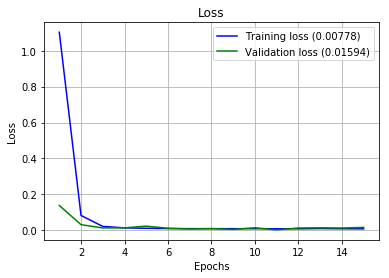

Score (RMSE): 0.1590049266225196


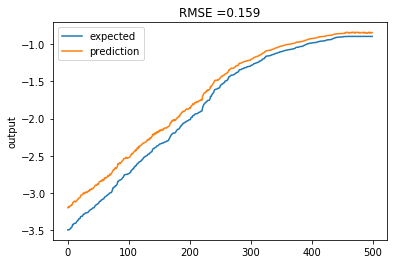

In [15]:
model = load_model('my_model.h5')

model.compile(Adam(lr=.0001),loss='mean_squared_error')


history = model.fit(train_data, train_label, epochs=15, batch_size=128, validation_split=0.1, verbose=1)

model.save('retrain_less.h5')
plot_history(history)



pred = model.predict(test_data, batch_size=128)
score = np.sqrt(metrics.mean_squared_error(pred,test_label))
print("Score (RMSE): {}".format(score))

chart_regression(pred.flatten(),test_label)

### Random MF

In [4]:
path_folder = 'matrix_del_rand_more/'
ex = '.npy'

if not os.path.exists(path_folder):
    os.mkdir(path_folder)

c_i = 8.

l = 8
j = 1
delt = -1

row = []
for i in range(0,5000):
    
    h = c_i*np.random.randn(l)
    
    Hxxz = np.zeros((2**l , 2**l ))

    # constructing the full xxz hamiltonian (2^L, 2^L) 
    for x in range(0,2**l):
        for y in range(0,l):
            k = (y+1)%l
            if check_nth_bit(x,y) == 0:
                Hxxz[x,x] += -j*h[y]/2
            else:
                Hxxz[x,x] += j*h[y]/2
            #if y != l-1:    
            if check_nth_bit(x,y) == check_nth_bit(x,k):
                Hxxz[x,x] += -(j*delt)/2
            else:
                Hxxz[x,x] += (j*delt)/2
                b = bitflip(x,y)
                c = bitflip(b,k)
                Hxxz[x,c] += -j
    #print(Hxxz)
       
    
    mag_array = np.zeros(l+1)
    E_array = np.zeros(l+1)
    a = 0
    for mag in range(-l,l+1,2):
    
        p = num_mag(mag)
        state = np.array(range(p))
        s = statep(state,mag)
        
        Hxxz_p = np.zeros((p,p))
        for x in range(0,p):
            for y in range(0,l):
                if check_nth_bit(s[x],y) == 0:
                    Hxxz_p[x,x] += -(j*h[y])/2
                else:
                    Hxxz_p[x,x] += (j*h[y])/2
                k = (y+1)%l
                #if y != l-1:
                if check_nth_bit(s[x],y) == check_nth_bit(s[x],k):
                    Hxxz_p[x,x] += -(j*delt)/2
                else:
                    Hxxz_p[x,x] += (j*delt)/2
                    b = bitflip(s[x],y)
                    c = bitflip(b,k)
                    D = np.where(s == c)
                    Hxxz_p[x,D] = -j
                                            
        #print(Hxxz_p)
        mag_array[a] = mag
        A = POWER_METHOD(Hxxz_p,p)
        E_array[a] = A[1] 
        psi_s = -mag_array[np.where(E_array == np.min(E_array))]
        a += 1
   
    row.append([str(i+1) + ex, np.min(E_array)/l])
    np.save(os.path.abspath(path_folder+str(i+1)), Hxxz)   
    #print('h:',h)
    #print('MAG_GS:', psi_s[0])
    #print('rhoE_array:', np.min(E_array)/l)
    
    
row = np.asarray(row)

data_set = pd.DataFrame(row)
data_set.to_csv("rand.csv")

In [5]:
dataset = pd.read_csv('rand.csv')


#writing the columns of the csv in an list
X_1 = dataset.iloc[:,1].values
Y_1 = dataset.iloc[:,2].values

W = np.random.permutation(np.c_[X_1.reshape(len(X_1), -1), Y_1.reshape(len(Y_1), -1)])

X = W[:, :X_1.size//len(X_1)].reshape(X_1.shape)
Y = W[:, X_1.size//len(X_1):].reshape(Y_1.shape)

x_train = np.array([X[i] for i in range((len(X)//10),len(X))])
y_train = np.array([Y[i] for i in range((len(Y)//10),len(Y))])

x_test = np.array([X[i] for i in range((len(X)//10))])
y_test = np.array([Y[i] for i in range((len(Y)//10))])


In [7]:
train_data = []

load_train_data = []
for file in x_train:
        path = os.path.abspath(path_folder+ file)
        H = np.load(path)
        load_train_data.append(H)
load_train_data = np.array(load_train_data)
train_data = load_train_data[:,:,:,np.newaxis]
train_data -= np.mean(train_data)
train_data /= np.std(train_data)

train_label = []
for file in y_train:
    train_label.append(file)
train_label = np.array(train_label)

test_data = []

load_test_data = []
for file in x_test:
        path = os.path.abspath(path_folder+ file)
        H = np.load(path)
        load_test_data.append(H)
load_test_data = np.array(load_test_data)
test_data = load_test_data[:,:,:,np.newaxis]
test_data -= np.mean(test_data)
test_data /= np.std(test_data)

test_label = []
for file in y_test:
    test_label.append(file)
test_label = np.array(test_label)

Train on 4050 samples, validate on 450 samples
Epoch 1/15
4050/4050 [==============================] - 1596s 394ms/step - loss: 1.1457 - val_loss: 0.3052
Epoch 2/15
4050/4050 [==============================] - 1595s 394ms/step - loss: 0.2809 - val_loss: 0.2620
Epoch 3/15
4050/4050 [==============================] - 1587s 392ms/step - loss: 0.2161 - val_loss: 0.1938
Epoch 4/15
4050/4050 [==============================] - 1598s 395ms/step - loss: 0.1726 - val_loss: 0.1338
Epoch 5/15
4050/4050 [==============================] - 1586s 392ms/step - loss: 0.1460 - val_loss: 0.1396
Epoch 6/15
4050/4050 [==============================] - 1595s 394ms/step - loss: 0.1229 - val_loss: 0.1077
Epoch 7/15
4050/4050 [==============================] - 1590s 393ms/step - loss: 0.1104 - val_loss: 0.1426
Epoch 8/15
4050/4050 [==============================] - 1585s 391ms/step - loss: 0.0964 - val_loss: 0.0771
Epoch 9/15
4050/4050 [==============================] - 1596s 394ms/step - loss: 0.1063 - val_los

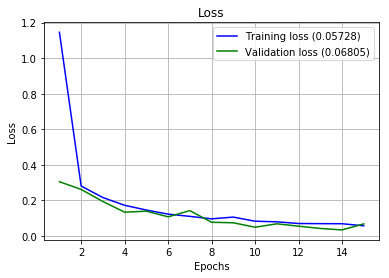

Score (RMSE): 0.22199094129479238


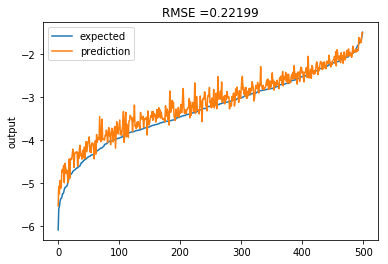

In [8]:
model = load_model('my_model.h5')

model.compile(Adam(lr=.0001),loss='mean_squared_error')


history = model.fit(train_data, train_label, epochs=15, batch_size=128, validation_split=0.1, verbose=1)

model.save('rand_train.h5')
plot_history(history)



pred = model.predict(test_data, batch_size=128)
score = np.sqrt(metrics.mean_squared_error(pred,test_label))
print("Score (RMSE): {}".format(score))

chart_regression(pred.flatten(),test_label)